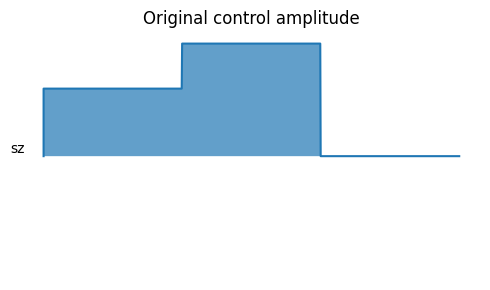

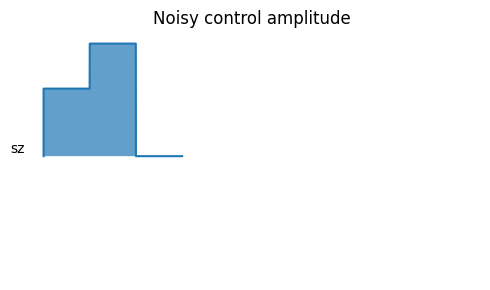

In [11]:
from qutip import sigmaz, sigmay
from qutip_qip.device import Processor
from qutip_qip.noise import RandomNoise

# add control Hamiltonians
processor = Processor(2)
processor.add_control(sigmaz(), targets=0, label="sz")

# define pulse coefficients and tlist for all pulses
processor.set_coeffs({"sz": np.array([0.3, 0.5, 0. ])})
tlist = np.array([0., np.pi/2., 2*np.pi/2, 3*np.pi/2])
processor.set_tlist(tlist)

# define noise, loc and scale are keyword arguments for np.random.normal
processor.add_noise(crosstalk_noise)

# Plot the ideal pulse
fig1, axis1 = processor.plot_pulses(
    title="Original control amplitude", figsize=(5,3),
    use_control_latex=False)

# Plot the noisy pulse
qobjevo, _ = processor.get_qobjevo(noisy=True)
noisy_coeff = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
fig2, axis2 = processor.plot_pulses(
    title="Noisy control amplitude", figsize=(5,3),
    use_control_latex=False)
axis2[0].step(qobjevo.tlist, noisy_coeff)

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip.qip.operations.gates import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

import os
import os.path

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_24760\958140696.py:17: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [2]:
class MyModel(Model):
    """A custom Hamiltonian model with sigmax and sigmay control."""

    def get_control(self, label):
        """
        Get an available control Hamiltonian.
        For instance, sigmax control on the zeroth
        qubits is labeled "sx0".

        Args:
            label (str): The label of the Hamiltonian

        Returns:
            The Hamiltonian and target qubits as a tuple
            (qutip.Qobj, list).
        """
        targets = int(label[2:])
        if label[:2] == "sx":
            return 2 * np.pi * sigmax() / 2, [targets]
        elif label[:2] == "sy":
            return 2 * np.pi * sigmay() / 2, [targets]
        else:
            raise NotImplementedError("Unknown control.")

In [3]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)

In [7]:
class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims) - 1):
            systematic_noise.add_control_noise(
                self.strength * zz_operator, targets=[i, i + 1],
                tlist=3*tlist, coeff=True
    )  # constant, always 1

crosstalk_noise = ZZ_crosstalk(strength=0.3)

In [132]:
circuit = QubitCircuit(2)
num_spin_flips = 10
myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX", "RY"]
mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 1})
myprocessor.add_control(sigmax(), targets=1, label="sx")

# define pulse coefficients and tlist for all pulses
myprocessor.set_coeffs({"sx": np.array([0.3, 0.5, 0. ])})
tlist = np.array([0., np.pi/2., 2*np.pi/2, 3*np.pi/2])
myprocessor.set_tlist({"sx": tlist})

for i in range(num_spin_flips):
    circuit.add_gate("sx",targets = 1)

myprocessor.load_circuit(circuit, compiler=mycompiler)


ValueError: invalid literal for int() with base 10: ''